# VAE Model trained using NSynth Dataset

### Install Packages

In [ ]:
!pip install numpy librosa matplotlib tensorflow Ipython

In [ ]:
!pip install scikit-learn noisereduce

### Dataset Loader

In [6]:
import os
import numpy as np
import librosa

def get_file_paths(directory, instrument_family):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav") and instrument_family in file and not file.startswith('._'):
                file_paths.append(os.path.join(root, file))
                #print(f"Found {file_paths[-1]}")
    return file_paths

def check_pitch_range(y, sr=16000, min_pitch=24, max_pitch=84):
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitches = np.argmax(pitches, axis=0)
    pitches = librosa.hz_to_midi(pitches)
    pitches = pitches[pitches > 0]
    return np.all((pitches >= min_pitch) & (pitches <= max_pitch))

def load_audio_files(file_paths, max_samples=500, sr=16000):
    audio_data = []
    for file_path in file_paths:
        if len(audio_data) >= max_samples:
            break
        try:
            y, _ = librosa.load(file_path, sr=sr)
            y = librosa.util.normalize(y)
            if check_pitch_range(y):
                audio_data.append(y)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return np.expand_dims(np.array(audio_data), -1)

# Chose from : 'bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal'
instrument_family = 'guitar'

train_file_paths = get_file_paths('../Nsynth/nsynth-train/audio', instrument_family)
valid_file_paths = get_file_paths('../Nsynth/nsynth-valid/audio', instrument_family)
test_file_paths = get_file_paths('../Nsynth/nsynth-test/audio', instrument_family)

train_data = load_audio_files(train_file_paths, max_samples=500)
valid_data = load_audio_files(valid_file_paths, max_samples=100)
test_data = load_audio_files(test_file_paths, max_samples=100)

/Users/nishantsaxena/Downloads/9491/.venv/lib/python3.11/site-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69


In [19]:
print(f"Loaded {len(train_data)} audio samples")
print(f"Loaded {len(valid_data)} audio samples")
print(f"Loaded {len(test_data)} audio samples")

Loaded 500 audio samples
Loaded 100 audio samples
Loaded 100 audio samples


In [20]:
# Check if audio_data has the correct shape
print(f"Train audio data shape: {train_data.shape}")
print(f"Validation audio data shape: {valid_data.shape}")
print(f"Test audio data shape: {test_data.shape}")

Train audio data shape: (500, 64000, 1)
Validation audio data shape: (100, 64000, 1)
Test audio data shape: (100, 64000, 1)


In [21]:
def check_data_validity(data):
    if np.any(np.isnan(data)) or np.any(np.isinf(data)):
        raise ValueError("Data contains NaN or Inf values")

check_data_validity(train_data)
check_data_validity(valid_data)
check_data_validity(test_data)

##### Ensure that all audio files have a fixed length of 64000, 
since each audio file in the dataset is prefixed to 64000, this cell block is unneeded for this particular execution

In [22]:
# import numpy as np


# def preprocess_audio(audio_data, fixed_length):
#     preprocessed_audio = []
#     for a in audio_data:
#         if len(a) < fixed_length:
#             a = np.pad(a, (0, fixed_length - len(a)), 'constant')
#         else:
#             a = a[:fixed_length]
#         preprocessed_audio.append(a)
#     return np.expand_dims(np.array(preprocessed_audio), axis=-1)

# preprocessed_audio = preprocess_audio(audio_data, fixed_length)


### CVAE Model

##### Model Training Parameters


In [7]:
# Set parameters
# batch_size = 64
input_shape = train_data.shape[1:]
print(f"Input shape: {input_shape}")
latent_dim = 16
learning_rate = 0.0001

Input shape: (64000, 1)


##### Model Architecture

In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Reshape, Conv1DTranspose, Lambda, Add
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanAbsoluteError
# from sklearn.metrics import mean_absolute_error
import tensorflow.keras.backend as K
# from tensorflow.keras.layers import BatchNormalization

In [3]:
# Sampling function for the VAE
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder Model
def build_encoder(input_shape, latent_dim):
    audio_input = Input(shape=input_shape, name='audio_input')

    x = Conv1D(64, kernel_size=2, activation='relu', padding='same')(audio_input)
    x = Conv1D(128, kernel_size=2, activation='relu', padding='same')(x)
    x = Flatten()(x)

    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(audio_input, [z_mean, z_log_var, z])
    return encoder

# Decoder Model
def build_decoder(latent_dim, output_shape):
    z_input = Input(shape=(latent_dim,), name='z_input')

    intermediate_dim = output_shape[0]
    x = Dense(intermediate_dim * 128, activation='relu')(z_input)  # Adjust size as needed
    x = Reshape((intermediate_dim, 128))(x)
    x = Conv1DTranspose(128, kernel_size=2, activation='relu', padding='same')(x)
    x = Conv1DTranspose(64, kernel_size=2, activation='relu', padding='same')(x)
    x = Conv1DTranspose(1, kernel_size=2, activation='sigmoid', padding='same')(x)

    decoder = Model(z_input, x)
    return decoder


In [4]:
def vae_loss(x, x_decoded_mean, z_mean, z_log_var, kl_weight=0.01):
    # Reconstruction loss
    xent_loss = K.mean(K.abs(x - x_decoded_mean))
    
    # KL divergence loss
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    
    # Sum KL loss across latent dimensions and mean across batch
    kl_loss = K.mean(kl_loss)
    
    return xent_loss + kl_weight * kl_loss

# Build VAE Model
def build_vae(input_shape, latent_dim, learning_rate):
    encoder = build_encoder(input_shape, latent_dim)
    print("Encoder Summary:")
    encoder.summary()
    decoder = build_decoder(latent_dim, input_shape)
    print("Decoder Summary:")
    decoder.summary()
    audio_input = Input(shape=input_shape, name='audio_input')

    z_mean, z_log_var, z = encoder(audio_input)
    decoded = decoder(z)

    vae = Model(audio_input, decoded)

    # Compile the VAE model with a custom loss function
    def vae_loss_function(x, x_decoded_mean):
        z_mean, z_log_var = encoder(x)[0], encoder(x)[1]
        return vae_loss(x, x_decoded_mean, z_mean, z_log_var)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    vae.compile(optimizer=optimizer, loss=vae_loss_function)
    return vae, encoder, decoder

##### Model Training

In [46]:
# Build and train the model
vae, encoder, decoder = build_vae(input_shape, latent_dim, learning_rate)
vae.summary()

Input shape: (64000, 1)
Encoder Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 64000, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 64000, 64) │        192 │ audio_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 64000,     │     16,512 │ conv1d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8192000)   │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │ 131,072,0… │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │ 131,072,0… │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 262,160,736 (1000.06 MB)

 Trainable params: 262,160,736 (1000.06 MB)

 Non-trainable params: 0 (0.00 B)

Decoder Summary:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_input (InputLayer)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8192000)        │   139,264,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 64000, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_6              │ (None, 64000, 128)     │        32,896 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_7              │ (None, 64000, 64)      │        16,448 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_8              │ (None, 64000, 1)       │           129 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,313,473 (531.44 MB)

 Trainable params: 139,313,473 (531.44 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ audio_input (InputLayer)        │ (None, 64000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ [(None, 16), (None,    │   262,160,736 │
│                                 │ 16), (None, 16)]       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ (None, 64000, 1)       │   139,313,473 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,474,209 (1.50 GB)

 Trainable params: 401,474,209 (1.50 GB)

 Non-trainable params: 0 (0.00 B)

In [47]:
callbacks = [
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint('val_autoencoder.keras', save_best_only=True)
]

history = vae.fit(train_data, train_data, epochs=50, batch_size=64, validation_data=(valid_data, valid_data), callbacks=callbacks)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 413s 49s/step - loss: 1.1698 - val_loss: 0.8058
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 378s 47s/step - loss: 0.8231 - val_loss: 0.6026
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 374s 47s/step - loss: 0.6212 - val_loss: 0.5324
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 377s 47s/step - loss: 0.5520 - val_loss: 0.5107
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 380s 48s/step - loss: 0.5280 - val_loss: 0.4956
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 381s 48s/step - loss: 0.5095 - val_loss: 0.4879
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 379s 47s/step - loss: 0.5004 - val_loss: 0.4789
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 381s 48s/step - loss: 0.4903 - val_loss: 0.4685
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 380s 47s/step - loss: 0.4787 - val_loss: 0.4557
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 378s 47s/step - loss: 0.4643 - val_loss: 0.4387
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 382s 48s/step - loss: 0.4485 - val_loss: 0.4174
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 380s 47s/step - loss: 0.4247 - val_lo

In [48]:
# Evaluate the model on the test set
test_loss = vae.evaluate(test_data, test_data)
print(f"Test loss: {test_loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.1579
Test loss: 0.14984634518623352


### Save Model

In [ ]:
vae.save("VAE_v3.keras");
encoder.save("VAE_encoder_v3.keras");
decoder.save("VAE_decoder_v3.keras");

In [50]:
import pickle
with open('history_read.pkl','wb') as file: # PUT Instrument name, eg. history_guitar.pkl
    pickle.dump(history.history, file)

### Load Model

v1 -> organ


v2 -> guitar

v3 -> reed

In [8]:
from tensorflow.keras.models import load_model

vae = load_model("VAE_v2.keras", custom_objects={'sampling': sampling, 'vae_loss_function': vae_loss}, safe_mode=False)
encoder = load_model("VAE_encoder_v2.keras", custom_objects={'sampling': sampling, 'vae_loss_function': vae_loss}, safe_mode=False)
decoder = load_model("VAE_decoder_v2.keras", custom_objects={'sampling': sampling, 'vae_loss_function': vae_loss}, safe_mode=False)

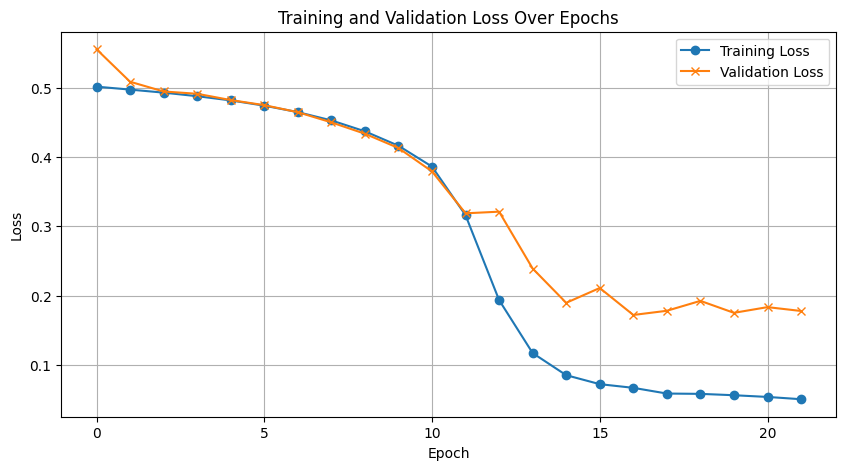

In [9]:
import pickle
import matplotlib.pyplot as plt

# Load the training history
with open('/Users/nishantsaxena/Downloads/9491/vae_guitar/history_guitar.pkl', 'rb') as file:  # Make sure to adjust the filename to match your specific file
    history = pickle.load(file)


plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### Generate Audio

After creating multiple models trained on specific instruments like guitar, organ, reed etc and saving multiple audio samples. 
We can Load and Visualise the audio

In [10]:
import matplotlib.pyplot as plt
import os
from scipy.io.wavfile import write

# Method to compute and plot the spectrogram
def plot_spectrogram(audio, sr=16000):
    S = librosa.feature.melspectrogram(y=audio.astype(np.float32), sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

# Method to display the audio waveform
def display_waveform(audio, sr=16000):
    audio_duration = len(audio) / sr
    plt.figure(figsize=(12, 4))
    plt.plot(np.linspace(0, audio_duration, len(audio)), audio)
    plt.title('Generated Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# Function to save audio files
def save_audio_files(audio_data, sr, base_filename, folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for i, audio in enumerate(audio_data):
        filename = f"{base_filename}_{i}.wav"
        file_path = os.path.join(folder_name, filename)
        # Ensure audio is properly scaled to [-1, 1] for saving
        audio = np.clip(audio, -1.0, 1.0)
        # Convert to 16-bit PCM format
        write(file_path, sr, (audio * 32767).astype(np.int16))
        print(f"Saved generated audio to {file_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


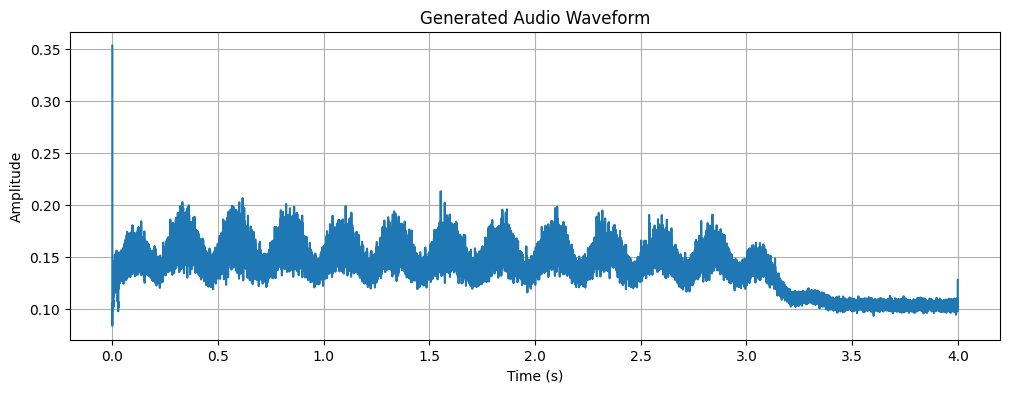

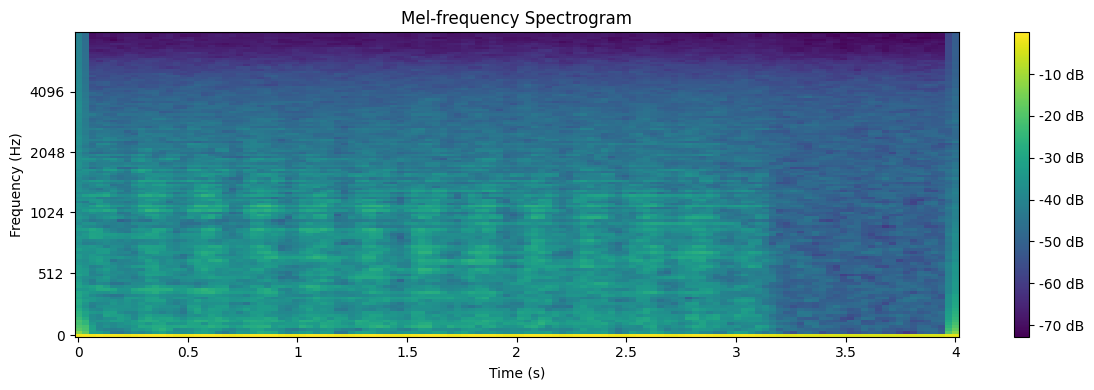

Generated audio saved.


In [10]:
import numpy as np
from scipy.io.wavfile import write
import IPython.display as ipy

# Function to generate audio using the trained model
def generate_audio(decoder, latent_dim, num_samples=1, sr=16000):
    random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
    generated_audio = decoder.predict(random_latent_vectors)
    return generated_audio

latent_dim = 16
# Generate and save audio
generated_audio = generate_audio(decoder, latent_dim, num_samples=1)
generated_audio = generated_audio.squeeze()  # Squeeze to remove single-dimensional entries

write('reed_generated_audio.wav', 16000, generated_audio)
display_waveform(generated_audio, sr=16000)
plot_spectrogram(generated_audio, sr=16000)
ipy.display(ipy.Audio(generated_audio, rate=16000))

print("Generated audio saved.")

Using Encoder and Decoder, 

Encoder breaks down the file to latent space from the test files dataset one by one, then using decoder to reconstruct the file from this latent space, effectively generating all 100 files 

In [11]:
import numpy as np
import tensorflow as tf
from IPython.display import Audio

# Function to encode audio samples to latent space
def encode_audio(encoder, audio_data):
    z_mean, z_log_var, z = encoder.predict(audio_data)
    return z  # Latent space representations

# Function to decode latent space representations to audio
def decode_latent(decoder, latent_representations):
    decoded_audio = decoder.predict(latent_representations)
    return decoded_audio

# Generate audio using the test dataset
encoded_test_data = encode_audio(encoder, test_data)
generated_audio = decode_latent(decoder, encoded_test_data)

#To show how many files are made
print(len(generated_audio))

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 526ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
100


In [12]:
# Save all 100 generated audio to files
save_audio_files(generated_audio.squeeze(), 16000, "generated_test_audio", "guitar")

Saved generated audio to guitar/generated_test_audio_0.wav
Saved generated audio to guitar/generated_test_audio_1.wav
Saved generated audio to guitar/generated_test_audio_2.wav
Saved generated audio to guitar/generated_test_audio_3.wav
Saved generated audio to guitar/generated_test_audio_4.wav
Saved generated audio to guitar/generated_test_audio_5.wav
Saved generated audio to guitar/generated_test_audio_6.wav
Saved generated audio to guitar/generated_test_audio_7.wav
Saved generated audio to guitar/generated_test_audio_8.wav
Saved generated audio to guitar/generated_test_audio_9.wav
Saved generated audio to guitar/generated_test_audio_10.wav
Saved generated audio to guitar/generated_test_audio_11.wav
Saved generated audio to guitar/generated_test_audio_12.wav
Saved generated audio to guitar/generated_test_audio_13.wav
Saved generated audio to guitar/generated_test_audio_14.wav
Saved generated audio to guitar/generated_test_audio_15.wav
Saved generated audio to guitar/generated_test_aud

Now these files can be loaded by name and displayed or run

In [44]:
import IPython.display as ipd

generated_audio = librosa.load('./reed/generated_test_audio_3.wav', sr=16000)[0]
# Call the methods
ipd.Audio(generated_audio, rate=16000)


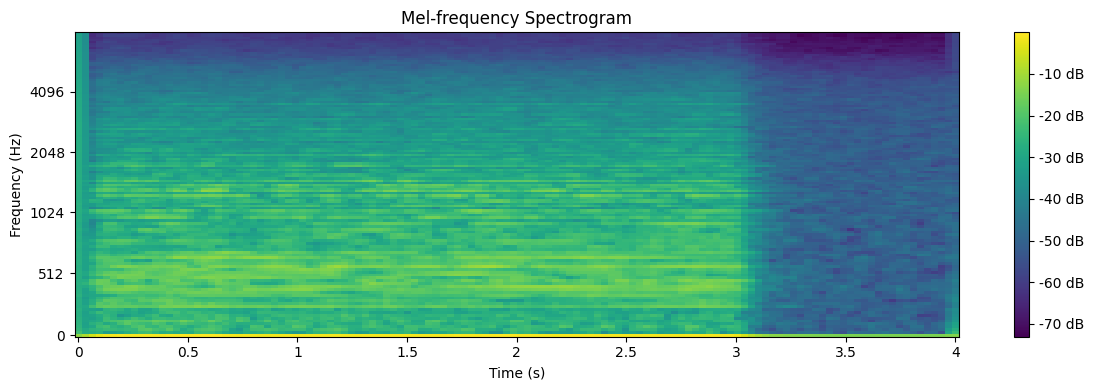

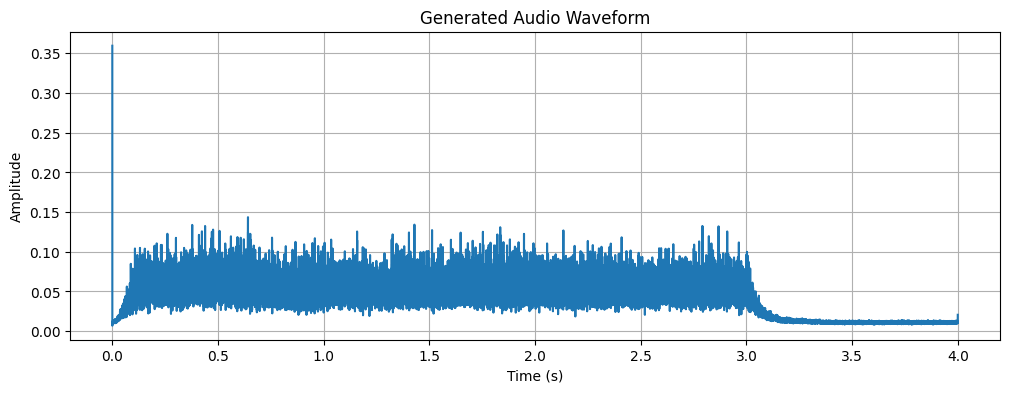

In [45]:
plot_spectrogram(generated_audio)
display_waveform(generated_audio)

### Clean up and visualise Audio

After creating multiple models trained on specific instruments like guitar, organ, etc and saving multiple audio samples. 
We can Load and Visualise the audio

In [14]:
import IPython.display as ipd
generated_audio = librosa.load('../vae_guitar/generated_audio.wav', sr=sr)[0]
# Call the methods
ipd.Audio(generated_audio, rate=sr)

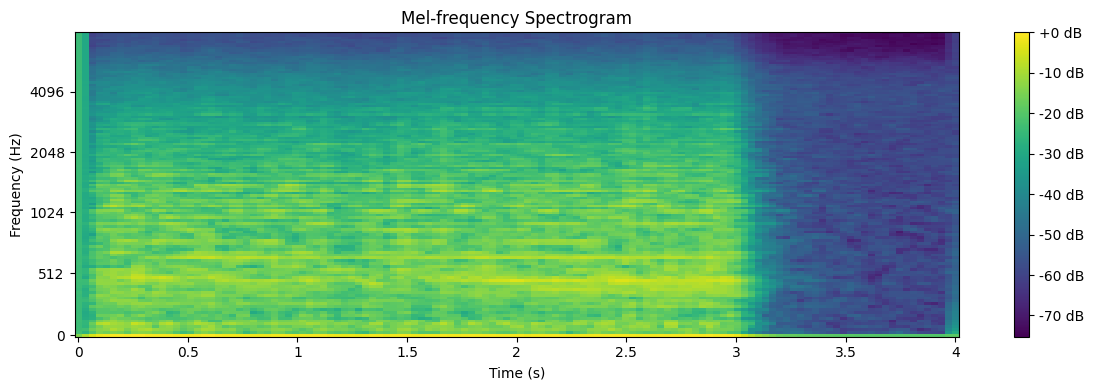

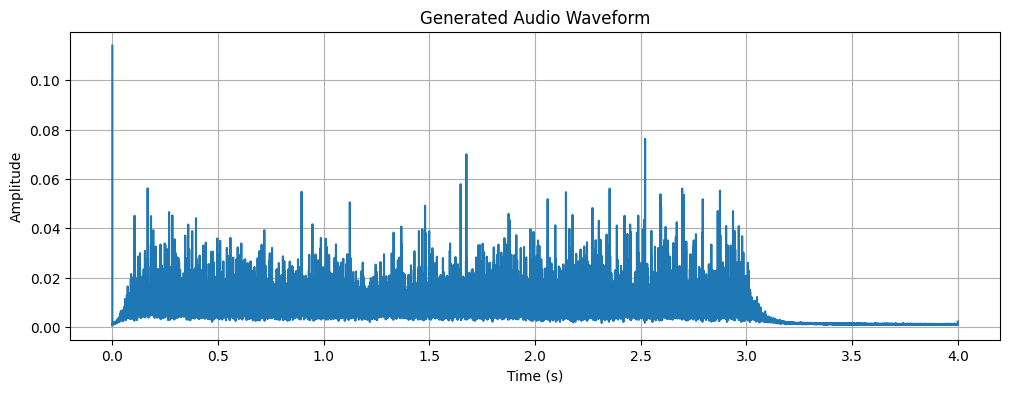

In [13]:
plot_spectrogram(generated_audio, sr)
display_waveform(generated_audio, sr)

Any attempt to clean the audio led to loosing the musical features of the audio as well 

In [15]:
import noisereduce as nr
# Perform noise reduction
cleaned_generated_audio = nr.reduce_noise(y=generated_audio, sr=16000)

ipd.Audio(cleaned_generated_audio, rate=sr)


/Users/nishantsaxena/Downloads/9491/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


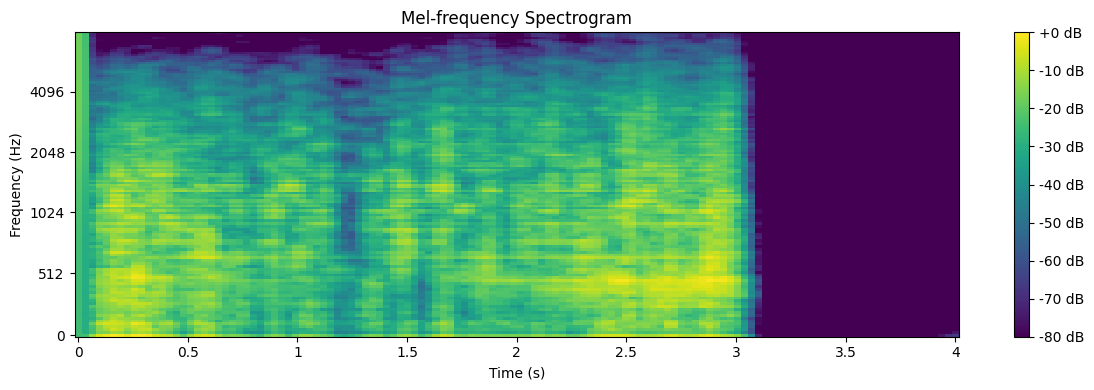

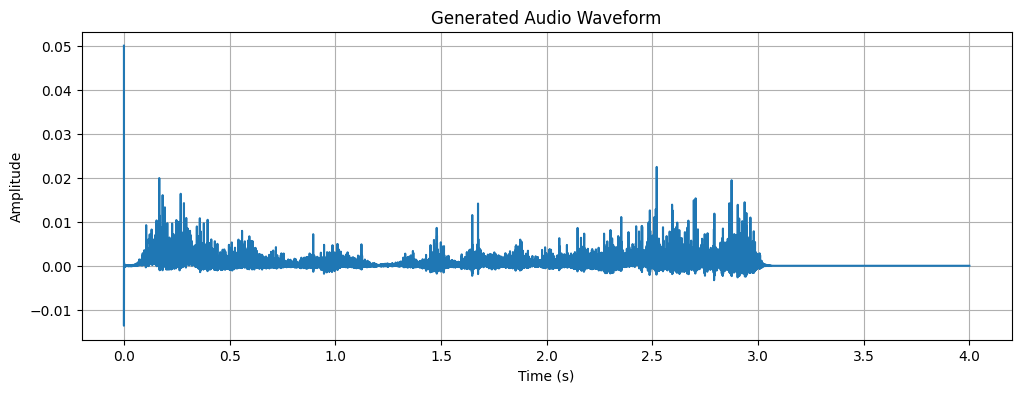

In [16]:
plot_spectrogram(cleaned_generated_audio, sr)
display_waveform(cleaned_generated_audio, sr)